# Pix2PixGAN：卡通照片真人化

# **1.导入需要的库**

In [1]:
import paddle
import paddle.nn as nn
from paddle.io import Dataset, DataLoader

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

def same_seeds(seed):
    paddle.seed(seed)
    np.random.seed(seed)

same_seeds(0)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matp

# **2.解压数据**
## 数据准备：

- 真人数据来自[seeprettyface](http://www.seeprettyface.com/mydataset.html)。
- 数据预处理（详情见[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目）。
<div>
  <img src='https://ai-studio-static-online.cdn.bcebos.com/c56c889827534363a8b6909d7737a1da64635ad33e1e44cb822f4c1cf1dfc689' height='1000px' width='1000px'>
</div>

- 使用[photo2cartoon](https://github.com/minivision-ai/photo2cartoon)项目生成真人数据对应的卡通数据。

In [2]:
# 解压数据
# !unzip -q data/data79149/cartoon_A2B.zip -d data/

# **3.数据可视化（已划分好数据集）**

训练集数据量: 1361
测试集数据量: 100


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


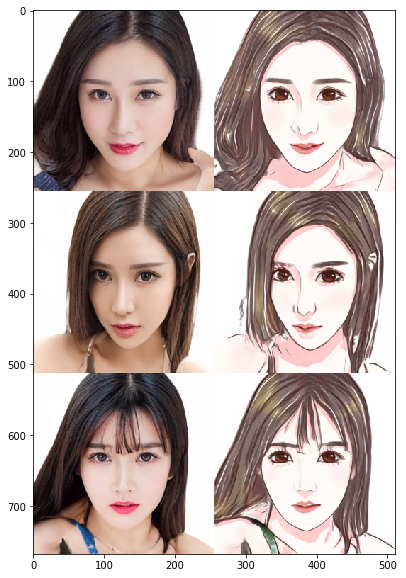

In [3]:
# 训练数据统计
train_names = os.listdir('data/cartoon_A2B/train')
print(f'训练集数据量: {len(train_names)}')

# 测试数据统计
test_names = os.listdir('data/cartoon_A2B/test')
print(f'测试集数据量: {len(test_names)}')

# 训练数据可视化
imgs = []
for img_name in np.random.choice(train_names, 3, replace=False):
    imgs.append(cv2.imread('data/cartoon_A2B/train/'+img_name))

img_show = np.vstack(imgs)[:,:,::-1]
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.show()

In [4]:
class PairedData(Dataset):
    def __init__(self, phase):
        super(PairedData, self).__init__() 
        self.img_path_list = self.load_A2B_data(phase)    # 获取数据列表
        self.num_samples = len(self.img_path_list)        # 数据量

    def __getitem__(self, idx):
        img_A2B = cv2.imread(self.img_path_list[idx])     # 读取数据
        img_A2B = img_A2B.astype('float32') / 127.5 - 1.  # 归一化
        img_A2B = img_A2B.transpose(2, 0, 1)              # HWC -> CHW
        img_A = img_A2B[..., :256]                        # 真人图（原图）   
        img_B = img_A2B[..., 256:]                        # 卡通图（标签）
        return img_A, img_B

    def __len__(self):
        return self.num_samples

    @staticmethod
    def load_A2B_data(phase):
        assert phase in ['train', 'test'], "phase should be set within ['train', 'test']"
        # 读取数据集，数据中每张图像包含照片和对应的卡通画。
        data_path = 'data/cartoon_A2B/'+phase
        return [os.path.join(data_path, x) for x in os.listdir(data_path)]

In [5]:
paired_dataset_train = PairedData('train')
paired_dataset_test = PairedData('test')

# **4.定义生成器**

In [6]:
class UnetGenerator(nn.Layer):
    def __init__(self, input_nc=3, output_nc=3, ngf=64):
        super(UnetGenerator, self).__init__()

        self.down1 = nn.Conv2D(input_nc, ngf, kernel_size=4, stride=2, padding=1)
        self.down2 = Downsample(ngf, ngf*2)
        self.down3 = Downsample(ngf*2, ngf*4)
        self.down4 = Downsample(ngf*4, ngf*8)
        self.down5 = Downsample(ngf*8, ngf*8)
        self.down6 = Downsample(ngf*8, ngf*8)
        self.down7 = Downsample(ngf*8, ngf*8)

        self.center = Downsample(ngf*8, ngf*8)

        self.up7 = Upsample(ngf*8, ngf*8, use_dropout=True)
        self.up6 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up5 = Upsample(ngf*8*2, ngf*8, use_dropout=True)
        self.up4 = Upsample(ngf*8*2, ngf*8)
        self.up3 = Upsample(ngf*8*2, ngf*4)
        self.up2 = Upsample(ngf*4*2, ngf*2)
        self.up1 = Upsample(ngf*2*2, ngf)

        self.output_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2DTranspose(ngf*2, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        
        c = self.center(d7)
        
        x = self.up7(c, d7)
        x = self.up6(x, d6)
        x = self.up5(x, d5)
        x = self.up4(x, d4)
        x = self.up3(x, d3)
        x = self.up2(x, d2)
        x = self.up1(x, d1)

        x = self.output_block(x)
        return x


class Downsample(nn.Layer):
    # LeakyReLU => conv => batch norm
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(Downsample, self).__init__()

        self.layers = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            nn.BatchNorm2D(out_dim)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class Upsample(nn.Layer):
    # ReLU => deconv => batch norm => dropout
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1, use_dropout=False):
        super(Upsample, self).__init__()

        sequence = [
            nn.ReLU(),
            nn.Conv2DTranspose(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            nn.BatchNorm2D(out_dim)
        ]

        if use_dropout:
            sequence.append(nn.Dropout(p=0.5))

        self.layers = nn.Sequential(*sequence)

    def forward(self, x, skip):
        x = self.layers(x)
        x = paddle.concat([x, skip], axis=1)
        return x

# **5.定义鉴别器**

In [7]:
class NLayerDiscriminator(nn.Layer):
    def __init__(self, input_nc=6, ndf=64):
        super(NLayerDiscriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(input_nc, ndf, kernel_size=4, stride=2, padding=1), 
            nn.LeakyReLU(0.2),
            
            ConvBlock(ndf, ndf*2),
            ConvBlock(ndf*2, ndf*4),
            ConvBlock(ndf*4, ndf*8, stride=1),

            nn.Conv2D(ndf*8, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.layers(input)


class ConvBlock(nn.Layer):
    # conv => batch norm => LeakyReLU
    def __init__(self, in_dim, out_dim, kernel_size=4, stride=2, padding=1):
        super(ConvBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2D(in_dim, out_dim, kernel_size, stride, padding, bias_attr=False),
            nn.BatchNorm2D(out_dim),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

## **实例化生成器，鉴别器**

In [8]:
def init_weight(w):
    if type(w) == nn.Linear or type(w) == nn.Conv2D or type(w) == nn.Conv2DTranspose:
        paddle.nn.initializer.KaimingNormal(w.weight)

In [9]:
generator = UnetGenerator()
discriminator = NLayerDiscriminator()
generator.apply(init_weight);
discriminator.apply(init_weight);

W0224 17:41:38.209228  3921 device_context.cc:362] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0224 17:41:38.213356  3921 device_context.cc:372] device: 0, cuDNN Version: 7.6.


In [10]:
out = generator(paddle.ones([1, 3, 256, 256]))
print('生成器输出尺寸：', out.shape)

out = discriminator(paddle.ones([1, 6, 256, 256]))
print('鉴别器输出尺寸：', out.shape)

生成器输出尺寸： [1, 3, 256, 256]
鉴别器输出尺寸： [1, 1, 30, 30]


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


# **6.定义训练各项超参数**

In [11]:
# 超参数
LR = 1e-4
BATCH_SIZE = 8
EPOCHS = 200
scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=0.0002, T_max=EPOCHS, verbose=True)

# 优化器
optimizerG = paddle.optimizer.Adam(
    learning_rate=scheduler,
    parameters=generator.parameters(),
    beta1=0.5,
    beta2=0.999)

optimizerD = paddle.optimizer.Adam(
    learning_rate=scheduler,
    parameters=discriminator.parameters(), 
    beta1=0.5,
    beta2=0.999)
    
# 损失函数
bce_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# dataloader
data_loader_train = DataLoader(
    paired_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
    )

data_loader_test = DataLoader(
    paired_dataset_test,
    batch_size=BATCH_SIZE,
    shuffle=True
    )

Epoch 0: CosineAnnealingDecay set learning rate to 0.0002.


# **7.训练**

In [12]:
results_save_path = 'work/results'
os.makedirs(results_save_path, exist_ok=True)  # 保存每个epoch的测试结果

weights_save_path = 'work/weights'
os.makedirs(weights_save_path, exist_ok=True)  # 保存模型

for epoch in range(EPOCHS):
    for data in tqdm(data_loader_train):
        real_A, real_B = data
        
        optimizerD.clear_grad()
        # D(real)
        real_AB = paddle.concat((real_A, real_B), 1)
        d_real_predict = discriminator(real_AB)
        d_real_loss = bce_loss(d_real_predict, paddle.ones_like(d_real_predict))

        # D(fake)
        fake_B = generator(real_A).detach()
        fake_AB = paddle.concat((real_A, fake_B), 1)
        d_fake_predict = discriminator(fake_AB)
        d_fake_loss = bce_loss(d_fake_predict, paddle.zeros_like(d_fake_predict))
        
        # train D
        d_loss = (d_real_loss + d_fake_loss) / 2.
        d_loss.backward()
        optimizerD.step()

        optimizerG.clear_grad()
        # D(fake)
        fake_B = generator(real_A)
        fake_AB = paddle.concat((real_A, fake_B), 1)
        g_fake_predict = discriminator(fake_AB)
        g_bce_loss = bce_loss(g_fake_predict, paddle.ones_like(g_fake_predict))
        g_l1_loss = l1_loss(fake_B, real_B) * 100.
        g_loss = g_bce_loss + g_l1_loss
        
        # train G
        g_loss.backward()
        optimizerG.step()
    scheduler.step()

    print(f'Epoch [{epoch+1}/{EPOCHS}] Loss D: {d_loss.numpy()}, Loss G: {g_loss.numpy()}')

    if (epoch+1) % 10 == 0:
        paddle.save(generator.state_dict(), os.path.join(weights_save_path, 'epoch'+str(epoch+1).zfill(3)+'.pdparams'))

        # test
        generator.eval()
        with paddle.no_grad():
            for data in data_loader_test:
                real_A, real_B = data
                break

            fake_B = generator(real_A)
            result = paddle.concat([real_A[:3], real_B[:3], fake_B[:3]], 3)

            result = result.detach().numpy().transpose(0, 2, 3, 1)
            result = np.vstack(result)
            result = (result * 127.5 + 127.5).astype(np.uint8)
    
        cv2.imwrite(os.path.join(results_save_path, 'epoch'+str(epoch+1).zfill(3)+'.png'), result)

        generator.train()

  0%|          | 0/170 [00:00<?, ?it/s]/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dataloader/dataloader_iter.py:89: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(slot[0], (np.ndarray, np.bool, numbers.Number)):
  1%|          | 1/170 [00:00<00:23,  7.15it/s]

Epoch 1: CosineAnnealingDecay set learning rate to 0.00019998766324816607.
Epoch [1/200] Loss D: [0.45881885], Loss G: [12.464251]


  1%|          | 1/170 [00:00<00:23,  7.15it/s]

Epoch 2: CosineAnnealingDecay set learning rate to 0.00019995065603657316.
Epoch [2/200] Loss D: [0.52229774], Loss G: [11.00598]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch 3: CosineAnnealingDecay set learning rate to 0.00019988898749619702.
Epoch [3/200] Loss D: [0.6490015], Loss G: [11.286757]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch 4: CosineAnnealingDecay set learning rate to 0.00019980267284282717.
Epoch [4/200] Loss D: [0.4974206], Loss G: [11.6272955]


  1%|          | 1/170 [00:00<00:23,  7.12it/s]

Epoch 5: CosineAnnealingDecay set learning rate to 0.0001996917333733128.
Epoch [5/200] Loss D: [0.580098], Loss G: [10.381542]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch 6: CosineAnnealingDecay set learning rate to 0.000199556196460308.
Epoch [6/200] Loss D: [1.0043173], Loss G: [10.103501]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch 7: CosineAnnealingDecay set learning rate to 0.000199396095545518.
Epoch [7/200] Loss D: [0.66740954], Loss G: [10.11874]


  1%|          | 1/170 [00:00<00:23,  7.08it/s]

Epoch 8: CosineAnnealingDecay set learning rate to 0.0001992114701314478.
Epoch [8/200] Loss D: [0.7205483], Loss G: [9.732651]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch 9: CosineAnnealingDecay set learning rate to 0.00019900236577165574.
Epoch [9/200] Loss D: [0.48270786], Loss G: [8.716836]


  1%|          | 2/170 [00:00<00:23,  7.05it/s]

100%|██████████| 170/170 [00:23<00:00,  7.37it/s]


Epoch 10: CosineAnnealingDecay set learning rate to 0.00019876883405951377.
Epoch [10/200] Loss D: [0.5167356], Loss G: [8.542064]


  1%|          | 1/170 [00:00<00:23,  7.06it/s]

Epoch 11: CosineAnnealingDecay set learning rate to 0.00019851093261547738.
Epoch [11/200] Loss D: [0.60018045], Loss G: [8.440276]


  1%|          | 2/170 [00:00<00:23,  7.15it/s]

  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch 12: CosineAnnealingDecay set learning rate to 0.00019822872507286888.
Epoch [12/200] Loss D: [0.6297163], Loss G: [9.029925]


  1%|          | 2/170 [00:00<00:23,  7.07it/s]

  1%|          | 1/170 [00:00<00:25,  6.63it/s]

Epoch 13: CosineAnnealingDecay set learning rate to 0.00019792228106217658.
Epoch [13/200] Loss D: [0.69401455], Loss G: [9.282111]


  1%|          | 1/170 [00:00<00:24,  6.88it/s]

Epoch 14: CosineAnnealingDecay set learning rate to 0.00019759167619387476.
Epoch [14/200] Loss D: [0.6566609], Loss G: [8.265777]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch 15: CosineAnnealingDecay set learning rate to 0.00019723699203976768.
Epoch [15/200] Loss D: [0.66719556], Loss G: [8.243492]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch 16: CosineAnnealingDecay set learning rate to 0.00019685831611286313.
Epoch [16/200] Loss D: [0.50938016], Loss G: [7.4146385]


  1%|          | 2/170 [00:00<00:23,  7.08it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.22it/s]

  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch 17: CosineAnnealingDecay set learning rate to 0.00019645574184577985.
Epoch [17/200] Loss D: [0.58062476], Loss G: [7.315863]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch 18: CosineAnnealingDecay set learning rate to 0.00019602936856769437.
Epoch [18/200] Loss D: [0.6768038], Loss G: [7.785108]


  1%|          | 2/170 [00:00<00:23,  7.06it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.16it/s]

  2%|▏         | 4/170 [00:00<00:22,  7.23it/s]

  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch 19: CosineAnnealingDecay set learning rate to 0.00019557930147983305.
Epoch [19/200] Loss D: [0.5873365], Loss G: [7.2646155]


100%|██████████| 170/170 [00:22<00:00,  7.40it/s]


Epoch 20: CosineAnnealingDecay set learning rate to 0.0001951056516295154.
Epoch [20/200] Loss D: [0.5933682], Loss G: [7.1959453]


  1%|          | 1/170 [00:00<00:24,  6.89it/s]

Epoch 21: CosineAnnealingDecay set learning rate to 0.00019460853588275457.
Epoch [21/200] Loss D: [0.5757774], Loss G: [6.4948564]


  1%|          | 1/170 [00:00<00:24,  6.86it/s]

Epoch 22: CosineAnnealingDecay set learning rate to 0.0001940880768954226.
Epoch [22/200] Loss D: [0.6170891], Loss G: [6.8332047]


  1%|          | 2/170 [00:00<00:24,  6.99it/s]

  1%|          | 1/170 [00:00<00:24,  6.90it/s]

Epoch 23: CosineAnnealingDecay set learning rate to 0.0001935444030829868.
Epoch [23/200] Loss D: [0.58544934], Loss G: [6.5663524]


  1%|          | 2/170 [00:00<00:23,  7.04it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.15it/s]

  2%|▏         | 4/170 [00:00<00:22,  7.23it/s]

  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch 24: CosineAnnealingDecay set learning rate to 0.0001929776485888252.
Epoch [24/200] Loss D: [0.66365284], Loss G: [6.329926]


  1%|          | 2/170 [00:00<00:23,  7.10it/s]

  1%|          | 1/170 [00:00<00:24,  6.94it/s]

Epoch 25: CosineAnnealingDecay set learning rate to 0.00019238795325112872.
Epoch [25/200] Loss D: [0.62655103], Loss G: [6.3044]


  1%|          | 1/170 [00:00<00:24,  6.90it/s]

Epoch 26: CosineAnnealingDecay set learning rate to 0.00019177546256839815.
Epoch [26/200] Loss D: [0.7210898], Loss G: [5.85187]


  1%|          | 2/170 [00:00<00:23,  7.01it/s]

  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch 27: CosineAnnealingDecay set learning rate to 0.00019114032766354456.
Epoch [27/200] Loss D: [0.6298459], Loss G: [6.0250945]


  1%|          | 1/170 [00:00<00:25,  6.73it/s]

Epoch 28: CosineAnnealingDecay set learning rate to 0.00019048270524660199.
Epoch [28/200] Loss D: [0.63190067], Loss G: [5.5811195]


  1%|          | 2/170 [00:00<00:24,  6.95it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.09it/s]

  1%|          | 1/170 [00:00<00:25,  6.55it/s]

Epoch 29: CosineAnnealingDecay set learning rate to 0.0001898027575760616.
Epoch [29/200] Loss D: [0.6308346], Loss G: [6.101753]


  1%|          | 2/170 [00:00<00:24,  6.82it/s]

100%|██████████| 170/170 [00:23<00:00,  7.28it/s]


Epoch 30: CosineAnnealingDecay set learning rate to 0.00018910065241883683.
Epoch [30/200] Loss D: [0.64413345], Loss G: [5.6625676]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch 31: CosineAnnealingDecay set learning rate to 0.00018837656300886942.
Epoch [31/200] Loss D: [0.6522008], Loss G: [6.142339]


  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch 32: CosineAnnealingDecay set learning rate to 0.00018763066800438642.
Epoch [32/200] Loss D: [0.60892594], Loss G: [5.4522257]


  1%|          | 2/170 [00:00<00:23,  7.10it/s]

  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch 33: CosineAnnealingDecay set learning rate to 0.00018686315144381919.
Epoch [33/200] Loss D: [0.6825945], Loss G: [5.8221703]


  1%|          | 1/170 [00:00<00:24,  6.87it/s]

Epoch 34: CosineAnnealingDecay set learning rate to 0.00018607420270039441.
Epoch [34/200] Loss D: [0.6358156], Loss G: [5.74025]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch 35: CosineAnnealingDecay set learning rate to 0.00018526401643540927.
Epoch [35/200] Loss D: [0.63091993], Loss G: [5.707285]


  1%|          | 2/170 [00:00<00:23,  7.13it/s]

  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch 36: CosineAnnealingDecay set learning rate to 0.00018443279255020157.
Epoch [36/200] Loss D: [0.6067587], Loss G: [5.724539]


  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch 37: CosineAnnealingDecay set learning rate to 0.0001835807361368271.
Epoch [37/200] Loss D: [0.59612566], Loss G: [5.195533]


  1%|          | 2/170 [00:00<00:23,  7.10it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.19it/s]

  2%|▏         | 4/170 [00:00<00:22,  7.28it/s]

  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch 38: CosineAnnealingDecay set learning rate to 0.00018270805742745622.
Epoch [38/200] Loss D: [0.6574517], Loss G: [5.7006845]


  1%|          | 2/170 [00:00<00:23,  7.07it/s]

  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch 39: CosineAnnealingDecay set learning rate to 0.0001818149717425024.
Epoch [39/200] Loss D: [0.65423924], Loss G: [5.0814047]


100%|██████████| 170/170 [00:23<00:00,  7.37it/s]


Epoch 40: CosineAnnealingDecay set learning rate to 0.0001809016994374948.
Epoch [40/200] Loss D: [0.6315317], Loss G: [5.1962476]


  1%|          | 1/170 [00:00<00:24,  6.90it/s]

Epoch 41: CosineAnnealingDecay set learning rate to 0.00017996846584870913.
Epoch [41/200] Loss D: [0.6362419], Loss G: [4.9383817]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch 42: CosineAnnealingDecay set learning rate to 0.0001790155012375691.
Epoch [42/200] Loss D: [0.6502471], Loss G: [5.366914]


  1%|          | 1/170 [00:00<00:24,  6.87it/s]

Epoch 43: CosineAnnealingDecay set learning rate to 0.00017804304073383304.
Epoch [43/200] Loss D: [0.63377976], Loss G: [4.8676453]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch 44: CosineAnnealingDecay set learning rate to 0.000177051324277579.
Epoch [44/200] Loss D: [0.66467524], Loss G: [4.6209693]


  1%|          | 1/170 [00:00<00:23,  7.11it/s]

Epoch 45: CosineAnnealingDecay set learning rate to 0.0001760405965600032.
Epoch [45/200] Loss D: [0.6525916], Loss G: [5.0272365]


  1%|          | 1/170 [00:00<00:23,  7.06it/s]

Epoch 46: CosineAnnealingDecay set learning rate to 0.00017501110696304604.
Epoch [46/200] Loss D: [0.68133837], Loss G: [4.8899274]


  1%|          | 2/170 [00:00<00:23,  7.17it/s]

  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch 47: CosineAnnealingDecay set learning rate to 0.00017396310949786104.
Epoch [47/200] Loss D: [1.4120743], Loss G: [5.2397223]


  1%|          | 2/170 [00:00<00:23,  7.12it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.22it/s]

  2%|▏         | 4/170 [00:00<00:22,  7.28it/s]

  1%|          | 1/170 [00:00<00:23,  7.06it/s]

Epoch 48: CosineAnnealingDecay set learning rate to 0.00017289686274214123.
Epoch [48/200] Loss D: [0.68952185], Loss G: [5.051334]


  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch 49: CosineAnnealingDecay set learning rate to 0.00017181262977631896.
Epoch [49/200] Loss D: [0.6718438], Loss G: [5.0227537]


100%|██████████| 170/170 [00:23<00:00,  7.29it/s]


Epoch 50: CosineAnnealingDecay set learning rate to 0.0001707106781186548.
Epoch [50/200] Loss D: [0.68912196], Loss G: [4.724339]


  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch 51: CosineAnnealingDecay set learning rate to 0.00016959127965923148.
Epoch [51/200] Loss D: [0.68701226], Loss G: [5.147545]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch 52: CosineAnnealingDecay set learning rate to 0.00016845471059286893.
Epoch [52/200] Loss D: [0.6486742], Loss G: [4.8098764]


  1%|          | 1/170 [00:00<00:24,  6.80it/s]

Epoch 53: CosineAnnealingDecay set learning rate to 0.00016730125135097737.
Epoch [53/200] Loss D: [0.73418283], Loss G: [5.2472496]


  1%|          | 1/170 [00:00<00:23,  7.11it/s]

Epoch 54: CosineAnnealingDecay set learning rate to 0.00016613118653236524.
Epoch [54/200] Loss D: [0.6646661], Loss G: [4.9272547]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch 55: CosineAnnealingDecay set learning rate to 0.0001649448048330184.
Epoch [55/200] Loss D: [0.7363841], Loss G: [4.2604938]


  1%|          | 2/170 [00:00<00:23,  7.06it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.16it/s]

  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch 56: CosineAnnealingDecay set learning rate to 0.00016374239897486902.
Epoch [56/200] Loss D: [0.62763023], Loss G: [4.248746]


  1%|          | 1/170 [00:00<00:24,  6.91it/s]

Epoch 57: CosineAnnealingDecay set learning rate to 0.00016252426563357058.
Epoch [57/200] Loss D: [0.65255284], Loss G: [4.6777296]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch 58: CosineAnnealingDecay set learning rate to 0.00016129070536529771.
Epoch [58/200] Loss D: [0.6458397], Loss G: [4.44115]


  1%|          | 2/170 [00:00<00:24,  6.95it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.06it/s]

  2%|▏         | 4/170 [00:00<00:23,  7.10it/s]

  1%|          | 1/170 [00:00<00:24,  6.77it/s]

Epoch 59: CosineAnnealingDecay set learning rate to 0.00016004202253258848.
Epoch [59/200] Loss D: [0.64808], Loss G: [4.946216]


  1%|          | 2/170 [00:00<00:24,  6.94it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.05it/s]

  2%|▏         | 4/170 [00:00<00:23,  7.11it/s]

100%|██████████| 170/170 [00:23<00:00,  7.30it/s]


Epoch 60: CosineAnnealingDecay set learning rate to 0.0001587785252292474.
Epoch [60/200] Loss D: [0.662238], Loss G: [4.3285246]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch 61: CosineAnnealingDecay set learning rate to 0.00015750052520432792.
Epoch [61/200] Loss D: [0.62809825], Loss G: [4.1800613]


  1%|          | 2/170 [00:00<00:23,  7.16it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.23it/s]

  1%|          | 1/170 [00:00<00:23,  7.09it/s]

Epoch 62: CosineAnnealingDecay set learning rate to 0.00015620833778521315.
Epoch [62/200] Loss D: [0.64349365], Loss G: [4.535062]


  1%|          | 2/170 [00:00<00:23,  7.16it/s]

  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch 63: CosineAnnealingDecay set learning rate to 0.00015490228179981325.
Epoch [63/200] Loss D: [0.67073965], Loss G: [4.746317]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch 64: CosineAnnealingDecay set learning rate to 0.00015358267949789971.
Epoch [64/200] Loss D: [0.5597914], Loss G: [4.487762]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch 65: CosineAnnealingDecay set learning rate to 0.00015224985647159495.
Epoch [65/200] Loss D: [0.5906571], Loss G: [4.846156]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch 66: CosineAnnealingDecay set learning rate to 0.0001509041415750372.
Epoch [66/200] Loss D: [0.51840746], Loss G: [5.5413837]


  1%|          | 2/170 [00:00<00:23,  7.07it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.16it/s]

  2%|▏         | 4/170 [00:00<00:22,  7.25it/s]

  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch 67: CosineAnnealingDecay set learning rate to 0.00014954586684324083.
Epoch [67/200] Loss D: [0.61121476], Loss G: [5.268926]


  1%|          | 2/170 [00:00<00:23,  7.06it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.18it/s]

  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch 68: CosineAnnealingDecay set learning rate to 0.00014817536741017158.
Epoch [68/200] Loss D: [0.42665526], Loss G: [5.4099865]


  1%|          | 1/170 [00:00<00:23,  7.06it/s]

Epoch 69: CosineAnnealingDecay set learning rate to 0.00014679298142605742.
Epoch [69/200] Loss D: [0.5702467], Loss G: [5.710499]


100%|██████████| 170/170 [00:23<00:00,  7.32it/s]


Epoch 70: CosineAnnealingDecay set learning rate to 0.00014539904997395477.
Epoch [70/200] Loss D: [0.40635338], Loss G: [5.513973]


  1%|          | 1/170 [00:00<00:24,  6.87it/s]

Epoch 71: CosineAnnealingDecay set learning rate to 0.00014399391698559157.
Epoch [71/200] Loss D: [0.38168493], Loss G: [6.8108335]


  1%|          | 1/170 [00:00<00:24,  6.94it/s]

Epoch 72: CosineAnnealingDecay set learning rate to 0.00014257792915650734.
Epoch [72/200] Loss D: [0.44500288], Loss G: [5.88211]


  1%|          | 1/170 [00:00<00:25,  6.51it/s]

Epoch 73: CosineAnnealingDecay set learning rate to 0.00014115143586051096.
Epoch [73/200] Loss D: [0.56541574], Loss G: [5.9797945]


  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch 74: CosineAnnealingDecay set learning rate to 0.00013971478906347814.
Epoch [74/200] Loss D: [0.19911289], Loss G: [6.267151]


  1%|          | 1/170 [00:00<00:24,  6.87it/s]

Epoch 75: CosineAnnealingDecay set learning rate to 0.00013826834323650908.
Epoch [75/200] Loss D: [0.232544], Loss G: [6.375826]


  1%|          | 1/170 [00:00<00:24,  6.91it/s]

Epoch 76: CosineAnnealingDecay set learning rate to 0.0001368124552684679.
Epoch [76/200] Loss D: [0.26246142], Loss G: [7.6949058]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch 77: CosineAnnealingDecay set learning rate to 0.0001353474843779258.
Epoch [77/200] Loss D: [0.38889074], Loss G: [6.2712946]


  1%|          | 2/170 [00:00<00:23,  7.08it/s]

  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch 78: CosineAnnealingDecay set learning rate to 0.00013387379202452925.
Epoch [78/200] Loss D: [0.6459141], Loss G: [6.1982746]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch 79: CosineAnnealingDecay set learning rate to 0.00013239174181981503.
Epoch [79/200] Loss D: [0.43934098], Loss G: [7.3205304]


100%|██████████| 170/170 [00:23<00:00,  7.37it/s]


Epoch 80: CosineAnnealingDecay set learning rate to 0.00013090169943749482.
Epoch [80/200] Loss D: [0.32376775], Loss G: [6.34529]


  1%|          | 1/170 [00:00<00:23,  7.10it/s]

Epoch 81: CosineAnnealingDecay set learning rate to 0.00012940403252323048.
Epoch [81/200] Loss D: [0.3574594], Loss G: [6.127681]


  1%|          | 1/170 [00:00<00:23,  7.12it/s]

Epoch 82: CosineAnnealingDecay set learning rate to 0.00012789911060392302.
Epoch [82/200] Loss D: [0.53453887], Loss G: [7.2816]


  1%|          | 2/170 [00:00<00:23,  7.22it/s]

  2%|▏         | 3/170 [00:00<00:22,  7.28it/s]

  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch 83: CosineAnnealingDecay set learning rate to 0.00012638730499653735.
Epoch [83/200] Loss D: [0.5839922], Loss G: [6.175129]


  1%|          | 1/170 [00:00<00:24,  6.83it/s]

Epoch 84: CosineAnnealingDecay set learning rate to 0.00012486898871648554.
Epoch [84/200] Loss D: [0.17662178], Loss G: [7.105813]


  1%|          | 2/170 [00:00<00:24,  6.97it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.08it/s]

  1%|          | 1/170 [00:00<00:23,  7.08it/s]

Epoch 85: CosineAnnealingDecay set learning rate to 0.00012334453638559062.
Epoch [85/200] Loss D: [0.4731354], Loss G: [5.705352]


  1%|          | 2/170 [00:00<00:23,  7.15it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.23it/s]

  1%|          | 1/170 [00:00<00:24,  6.94it/s]

Epoch 86: CosineAnnealingDecay set learning rate to 0.00012181432413965435.
Epoch [86/200] Loss D: [0.21503036], Loss G: [6.21576]


  1%|          | 1/170 [00:00<00:24,  6.90it/s]

Epoch 87: CosineAnnealingDecay set learning rate to 0.00012027872953565135.
Epoch [87/200] Loss D: [0.20304886], Loss G: [6.4226117]


  1%|          | 2/170 [00:00<00:23,  7.05it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.16it/s]

  1%|          | 1/170 [00:00<00:24,  6.80it/s]

Epoch 88: CosineAnnealingDecay set learning rate to 0.00011873813145857257.
Epoch [88/200] Loss D: [0.51043755], Loss G: [6.0194235]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch 89: CosineAnnealingDecay set learning rate to 0.00011719291002794102.
Epoch [89/200] Loss D: [0.4253227], Loss G: [5.6068172]


100%|██████████| 170/170 [00:23<00:00,  7.32it/s]


Epoch 90: CosineAnnealingDecay set learning rate to 0.00011564344650402317.
Epoch [90/200] Loss D: [0.6920366], Loss G: [5.8790812]


  1%|          | 1/170 [00:00<00:24,  6.89it/s]

Epoch 91: CosineAnnealingDecay set learning rate to 0.00011409012319375836.
Epoch [91/200] Loss D: [0.6614106], Loss G: [6.0427265]


  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch 92: CosineAnnealingDecay set learning rate to 0.00011253332335643053.
Epoch [92/200] Loss D: [0.2959389], Loss G: [6.017634]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch 93: CosineAnnealingDecay set learning rate to 0.00011097343110910461.
Epoch [93/200] Loss D: [0.19990289], Loss G: [7.243761]


  1%|          | 2/170 [00:00<00:23,  7.07it/s]

  1%|          | 1/170 [00:00<00:24,  6.94it/s]

Epoch 94: CosineAnnealingDecay set learning rate to 0.00010941083133185151.
Epoch [94/200] Loss D: [0.53062457], Loss G: [6.2460785]


  1%|          | 2/170 [00:00<00:23,  7.02it/s]

  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch 95: CosineAnnealingDecay set learning rate to 0.00010784590957278459.
Epoch [95/200] Loss D: [0.0736488], Loss G: [7.405022]


  1%|          | 1/170 [00:00<00:25,  6.70it/s]

Epoch 96: CosineAnnealingDecay set learning rate to 0.00010627905195293144.
Epoch [96/200] Loss D: [0.36993334], Loss G: [5.6491394]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch 97: CosineAnnealingDecay set learning rate to 0.00010471064507096434.
Epoch [97/200] Loss D: [0.5266365], Loss G: [6.0769434]


  1%|          | 1/170 [00:00<00:23,  7.06it/s]

Epoch 98: CosineAnnealingDecay set learning rate to 0.00010314107590781291.
Epoch [98/200] Loss D: [0.20392816], Loss G: [6.236825]


  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch 99: CosineAnnealingDecay set learning rate to 0.00010157073173118215.
Epoch [99/200] Loss D: [0.06999644], Loss G: [8.414858]


  1%|          | 2/170 [00:00<00:23,  7.09it/s]

100%|██████████| 170/170 [00:23<00:00,  7.33it/s]


Epoch 100: CosineAnnealingDecay set learning rate to 0.00010000000000000007.
Epoch [100/200] Loss D: [0.7737048], Loss G: [6.132968]


  1%|          | 1/170 [00:00<00:23,  7.08it/s]

Epoch 101: CosineAnnealingDecay set learning rate to 9.842926826881802e-05.
Epoch [101/200] Loss D: [0.7157045], Loss G: [5.6245556]


  1%|          | 2/170 [00:00<00:23,  7.16it/s]

  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch 102: CosineAnnealingDecay set learning rate to 9.685892409218724e-05.
Epoch [102/200] Loss D: [0.48016056], Loss G: [7.4822574]


  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch 103: CosineAnnealingDecay set learning rate to 9.52893549290358e-05.
Epoch [103/200] Loss D: [0.40471002], Loss G: [6.485231]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch 104: CosineAnnealingDecay set learning rate to 9.372094804706872e-05.
Epoch [104/200] Loss D: [0.33910888], Loss G: [5.901864]


  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch 105: CosineAnnealingDecay set learning rate to 9.215409042721559e-05.
Epoch [105/200] Loss D: [0.8506563], Loss G: [5.6551805]


  1%|          | 1/170 [00:00<00:23,  7.14it/s]

Epoch 106: CosineAnnealingDecay set learning rate to 9.058916866814863e-05.
Epoch [106/200] Loss D: [0.3381131], Loss G: [6.552915]


  1%|          | 2/170 [00:00<00:23,  7.23it/s]

  2%|▏         | 3/170 [00:00<00:22,  7.28it/s]

  2%|▏         | 4/170 [00:00<00:22,  7.31it/s]

  1%|          | 1/170 [00:00<00:24,  6.86it/s]

Epoch 107: CosineAnnealingDecay set learning rate to 8.902656889089554e-05.
Epoch [107/200] Loss D: [0.3974646], Loss G: [5.8775926]


  1%|          | 1/170 [00:00<00:23,  7.10it/s]

Epoch 108: CosineAnnealingDecay set learning rate to 8.746667664356964e-05.
Epoch [108/200] Loss D: [0.55646735], Loss G: [5.8964815]


  1%|          | 2/170 [00:00<00:23,  7.15it/s]

  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch 109: CosineAnnealingDecay set learning rate to 8.590987680624182e-05.
Epoch [109/200] Loss D: [0.5103619], Loss G: [5.653002]


100%|██████████| 170/170 [00:23<00:00,  7.29it/s]


Epoch 110: CosineAnnealingDecay set learning rate to 8.435655349597699e-05.
Epoch [110/200] Loss D: [0.14072478], Loss G: [6.689788]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch 111: CosineAnnealingDecay set learning rate to 8.280708997205911e-05.
Epoch [111/200] Loss D: [0.45556885], Loss G: [5.4633346]


  1%|          | 2/170 [00:00<00:23,  7.07it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.18it/s]

  2%|▏         | 4/170 [00:00<00:23,  7.22it/s]

  1%|          | 1/170 [00:00<00:23,  7.04it/s]

Epoch 112: CosineAnnealingDecay set learning rate to 8.126186854142761e-05.
Epoch [112/200] Loss D: [0.47418016], Loss G: [6.6177874]


  1%|          | 2/170 [00:00<00:23,  7.16it/s]

  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch 113: CosineAnnealingDecay set learning rate to 7.972127046434884e-05.
Epoch [113/200] Loss D: [0.21675208], Loss G: [6.1271944]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch 114: CosineAnnealingDecay set learning rate to 7.818567586034585e-05.
Epoch [114/200] Loss D: [0.42657804], Loss G: [5.765442]


  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch 115: CosineAnnealingDecay set learning rate to 7.665546361440952e-05.
Epoch [115/200] Loss D: [0.50139356], Loss G: [6.2211742]


  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch 116: CosineAnnealingDecay set learning rate to 7.513101128351459e-05.
Epoch [116/200] Loss D: [0.33330792], Loss G: [5.838483]


  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch 117: CosineAnnealingDecay set learning rate to 7.361269500346278e-05.
Epoch [117/200] Loss D: [0.22980365], Loss G: [6.0574245]


  1%|          | 2/170 [00:00<00:23,  7.09it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.22it/s]

  1%|          | 1/170 [00:00<00:24,  6.91it/s]

Epoch 118: CosineAnnealingDecay set learning rate to 7.210088939607715e-05.
Epoch [118/200] Loss D: [0.63298416], Loss G: [5.675867]


  1%|          | 1/170 [00:00<00:23,  7.08it/s]

Epoch 119: CosineAnnealingDecay set learning rate to 7.059596747676969e-05.
Epoch [119/200] Loss D: [0.5160269], Loss G: [6.0858383]


100%|██████████| 170/170 [00:23<00:00,  7.33it/s]


Epoch 120: CosineAnnealingDecay set learning rate to 6.909830056250537e-05.
Epoch [120/200] Loss D: [0.26339415], Loss G: [6.3076906]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch 121: CosineAnnealingDecay set learning rate to 6.760825818018512e-05.
Epoch [121/200] Loss D: [0.5639441], Loss G: [5.875333]


  1%|          | 2/170 [00:00<00:23,  7.13it/s]

  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch 122: CosineAnnealingDecay set learning rate to 6.612620797547093e-05.
Epoch [122/200] Loss D: [0.60001945], Loss G: [5.6931047]


  1%|          | 2/170 [00:00<00:23,  7.17it/s]

  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch 123: CosineAnnealingDecay set learning rate to 6.465251562207437e-05.
Epoch [123/200] Loss D: [0.46782732], Loss G: [5.361051]


  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch 124: CosineAnnealingDecay set learning rate to 6.318754473153229e-05.
Epoch [124/200] Loss D: [0.3840531], Loss G: [5.7209654]


  1%|          | 1/170 [00:00<00:24,  6.94it/s]

Epoch 125: CosineAnnealingDecay set learning rate to 6.173165676349111e-05.
Epoch [125/200] Loss D: [0.3585001], Loss G: [6.843692]


  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch 126: CosineAnnealingDecay set learning rate to 6.028521093652199e-05.
Epoch [126/200] Loss D: [0.35733753], Loss G: [5.8429384]


  1%|          | 1/170 [00:00<00:24,  6.95it/s]

Epoch 127: CosineAnnealingDecay set learning rate to 5.884856413948919e-05.
Epoch [127/200] Loss D: [0.5780801], Loss G: [5.321245]


  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch 128: CosineAnnealingDecay set learning rate to 5.74220708434928e-05.
Epoch [128/200] Loss D: [0.19977489], Loss G: [7.2990932]


  1%|          | 2/170 [00:00<00:23,  7.10it/s]

  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch 129: CosineAnnealingDecay set learning rate to 5.6006083014408545e-05.
Epoch [129/200] Loss D: [0.6012285], Loss G: [5.329016]


  1%|          | 2/170 [00:00<00:23,  7.14it/s]

100%|██████████| 170/170 [00:23<00:00,  7.36it/s]


Epoch 130: CosineAnnealingDecay set learning rate to 5.460095002604539e-05.
Epoch [130/200] Loss D: [0.44346917], Loss G: [5.678287]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch 131: CosineAnnealingDecay set learning rate to 5.320701857394274e-05.
Epoch [131/200] Loss D: [0.3046474], Loss G: [6.564993]


  1%|          | 2/170 [00:00<00:23,  7.16it/s]

  1%|          | 1/170 [00:00<00:24,  6.94it/s]

Epoch 132: CosineAnnealingDecay set learning rate to 5.182463258982851e-05.
Epoch [132/200] Loss D: [0.810153], Loss G: [5.177149]


  1%|          | 2/170 [00:00<00:23,  7.07it/s]

  1%|          | 1/170 [00:00<00:23,  7.04it/s]

Epoch 133: CosineAnnealingDecay set learning rate to 5.045413315675929e-05.
Epoch [133/200] Loss D: [0.54175866], Loss G: [5.2782]


  1%|          | 2/170 [00:00<00:23,  7.14it/s]

  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch 134: CosineAnnealingDecay set learning rate to 4.909585842496292e-05.
Epoch [134/200] Loss D: [0.6594216], Loss G: [4.850547]


  1%|          | 2/170 [00:00<00:23,  7.08it/s]

  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch 135: CosineAnnealingDecay set learning rate to 4.7750143528405166e-05.
Epoch [135/200] Loss D: [0.2623643], Loss G: [5.849494]


  1%|          | 2/170 [00:00<00:23,  7.14it/s]

  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch 136: CosineAnnealingDecay set learning rate to 4.641732050210036e-05.
Epoch [136/200] Loss D: [0.7622027], Loss G: [4.9043484]


  1%|          | 2/170 [00:00<00:23,  7.09it/s]

  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch 137: CosineAnnealingDecay set learning rate to 4.5097718200186855e-05.
Epoch [137/200] Loss D: [0.76504934], Loss G: [5.658511]


  1%|          | 2/170 [00:00<00:23,  7.13it/s]

  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch 138: CosineAnnealingDecay set learning rate to 4.3791662214786975e-05.
Epoch [138/200] Loss D: [0.5519738], Loss G: [4.869142]


  1%|          | 2/170 [00:00<00:23,  7.07it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.17it/s]

  2%|▏         | 4/170 [00:00<00:22,  7.23it/s]

  1%|          | 1/170 [00:00<00:23,  7.09it/s]

Epoch 139: CosineAnnealingDecay set learning rate to 4.249947479567219e-05.
Epoch [139/200] Loss D: [0.4410056], Loss G: [5.2340393]


  1%|          | 2/170 [00:00<00:24,  6.76it/s]

100%|██████████| 170/170 [00:23<00:00,  7.29it/s]


Epoch 140: CosineAnnealingDecay set learning rate to 4.1221474770752745e-05.
Epoch [140/200] Loss D: [0.40017778], Loss G: [5.695473]


  1%|          | 1/170 [00:00<00:24,  6.90it/s]

Epoch 141: CosineAnnealingDecay set learning rate to 3.9957977467411655e-05.
Epoch [141/200] Loss D: [0.28270394], Loss G: [6.153779]


  1%|          | 2/170 [00:00<00:23,  7.05it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.15it/s]

  2%|▏         | 4/170 [00:00<00:23,  7.19it/s]

  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch 142: CosineAnnealingDecay set learning rate to 3.870929463470238e-05.
Epoch [142/200] Loss D: [0.5672815], Loss G: [5.0501804]


  1%|          | 2/170 [00:00<00:23,  7.05it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.19it/s]

  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch 143: CosineAnnealingDecay set learning rate to 3.747573436642952e-05.
Epoch [143/200] Loss D: [0.65448505], Loss G: [4.831023]


  1%|          | 2/170 [00:00<00:23,  7.18it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.23it/s]

  2%|▏         | 4/170 [00:00<00:22,  7.28it/s]

  3%|▎         | 5/170 [00:00<00:22,  7.32it/s]

  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch 144: CosineAnnealingDecay set learning rate to 3.625760102513106e-05.
Epoch [144/200] Loss D: [0.6473099], Loss G: [4.702343]


  1%|          | 2/170 [00:00<00:23,  7.11it/s]

  1%|          | 1/170 [00:00<00:23,  7.04it/s]

Epoch 145: CosineAnnealingDecay set learning rate to 3.505519516698168e-05.
Epoch [145/200] Loss D: [0.7014297], Loss G: [4.787934]


  1%|          | 2/170 [00:00<00:23,  7.13it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.21it/s]

  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch 146: CosineAnnealingDecay set learning rate to 3.386881346763486e-05.
Epoch [146/200] Loss D: [0.7292615], Loss G: [4.6431484]


  1%|          | 2/170 [00:00<00:23,  7.16it/s]

  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch 147: CosineAnnealingDecay set learning rate to 3.269874864902269e-05.
Epoch [147/200] Loss D: [0.42128652], Loss G: [5.834428]


  1%|          | 2/170 [00:00<00:23,  7.08it/s]

  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch 148: CosineAnnealingDecay set learning rate to 3.154528940713116e-05.
Epoch [148/200] Loss D: [0.42653713], Loss G: [5.496946]


  1%|          | 2/170 [00:00<00:23,  7.06it/s]

  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch 149: CosineAnnealingDecay set learning rate to 3.04087203407686e-05.
Epoch [149/200] Loss D: [0.33829266], Loss G: [5.848468]


  1%|          | 2/170 [00:00<00:23,  7.14it/s]

100%|██████████| 170/170 [00:23<00:00,  7.34it/s]


Epoch 150: CosineAnnealingDecay set learning rate to 2.9289321881345285e-05.
Epoch [150/200] Loss D: [0.5966866], Loss G: [4.846381]


  1%|          | 1/170 [00:00<00:24,  6.93it/s]

Epoch 151: CosineAnnealingDecay set learning rate to 2.818737022368116e-05.
Epoch [151/200] Loss D: [0.7030341], Loss G: [4.5818386]


  1%|          | 2/170 [00:00<00:23,  7.05it/s]

  2%|▏         | 3/170 [00:00<00:28,  5.89it/s]

  2%|▏         | 4/170 [00:00<00:26,  6.26it/s]

  1%|          | 1/170 [00:00<00:24,  6.91it/s]

Epoch 152: CosineAnnealingDecay set learning rate to 2.7103137257858895e-05.
Epoch [152/200] Loss D: [0.37661487], Loss G: [5.2429323]


  1%|          | 2/170 [00:00<00:23,  7.02it/s]

  2%|▏         | 3/170 [00:00<00:24,  6.84it/s]

  2%|▏         | 4/170 [00:00<00:23,  6.99it/s]

  3%|▎         | 5/170 [00:00<00:23,  7.06it/s]

  1%|          | 1/170 [00:00<00:23,  7.08it/s]

Epoch 153: CosineAnnealingDecay set learning rate to 2.6036890502139048e-05.
Epoch [153/200] Loss D: [0.48145095], Loss G: [5.1657495]


  1%|          | 2/170 [00:00<00:23,  7.14it/s]

  1%|          | 1/170 [00:00<00:23,  7.06it/s]

Epoch 154: CosineAnnealingDecay set learning rate to 2.4988893036954067e-05.
Epoch [154/200] Loss D: [0.44198698], Loss G: [5.0394564]


  1%|          | 2/170 [00:00<00:23,  7.10it/s]

  1%|          | 1/170 [00:00<00:25,  6.59it/s]

Epoch 155: CosineAnnealingDecay set learning rate to 2.3959403439996934e-05.
Epoch [155/200] Loss D: [0.60480946], Loss G: [4.630256]


  1%|          | 2/170 [00:00<00:24,  6.89it/s]

  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch 156: CosineAnnealingDecay set learning rate to 2.294867572242111e-05.
Epoch [156/200] Loss D: [0.4545155], Loss G: [4.912284]


  1%|          | 2/170 [00:00<00:24,  6.75it/s]

  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch 157: CosineAnnealingDecay set learning rate to 2.1956959266167064e-05.
Epoch [157/200] Loss D: [0.53741753], Loss G: [4.8286014]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch 158: CosineAnnealingDecay set learning rate to 2.0984498762430978e-05.
Epoch [158/200] Loss D: [0.874048], Loss G: [4.475851]


  1%|          | 1/170 [00:00<00:23,  7.08it/s]

Epoch 159: CosineAnnealingDecay set learning rate to 2.003153415129096e-05.
Epoch [159/200] Loss D: [0.56499505], Loss G: [4.644975]


100%|██████████| 170/170 [00:23<00:00,  7.37it/s]


Epoch 160: CosineAnnealingDecay set learning rate to 1.9098300562505283e-05.
Epoch [160/200] Loss D: [0.8822397], Loss G: [4.435401]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch 161: CosineAnnealingDecay set learning rate to 1.8185028257497687e-05.
Epoch [161/200] Loss D: [0.7206988], Loss G: [4.6933713]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch 162: CosineAnnealingDecay set learning rate to 1.7291942572543845e-05.
Epoch [162/200] Loss D: [0.53902906], Loss G: [5.0176682]


  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch 163: CosineAnnealingDecay set learning rate to 1.641926386317301e-05.
Epoch [163/200] Loss D: [0.6691489], Loss G: [4.4088006]


  1%|          | 2/170 [00:00<00:23,  7.16it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.17it/s]

  1%|          | 1/170 [00:00<00:23,  7.10it/s]

Epoch 164: CosineAnnealingDecay set learning rate to 1.556720744979853e-05.
Epoch [164/200] Loss D: [0.5517267], Loss G: [4.657979]


  1%|          | 1/170 [00:00<00:24,  6.87it/s]

Epoch 165: CosineAnnealingDecay set learning rate to 1.4735983564590818e-05.
Epoch [165/200] Loss D: [0.66946584], Loss G: [4.516211]


  1%|          | 2/170 [00:00<00:24,  6.99it/s]

  1%|          | 1/170 [00:00<00:24,  7.01it/s]

Epoch 166: CosineAnnealingDecay set learning rate to 1.3925797299605636e-05.
Epoch [166/200] Loss D: [0.57024944], Loss G: [4.8731813]


  1%|          | 2/170 [00:00<00:23,  7.09it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.22it/s]

  2%|▏         | 4/170 [00:00<00:22,  7.28it/s]

  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch 167: CosineAnnealingDecay set learning rate to 1.313684855618088e-05.
Epoch [167/200] Loss D: [0.70408154], Loss G: [4.481229]


  1%|          | 1/170 [00:00<00:23,  7.06it/s]

Epoch 168: CosineAnnealingDecay set learning rate to 1.2369331995613651e-05.
Epoch [168/200] Loss D: [0.60173905], Loss G: [4.474326]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch 169: CosineAnnealingDecay set learning rate to 1.1623436991130663e-05.
Epoch [169/200] Loss D: [0.64533436], Loss G: [4.3512754]


100%|██████████| 170/170 [00:23<00:00,  7.34it/s]


Epoch 170: CosineAnnealingDecay set learning rate to 1.089934758116323e-05.
Epoch [170/200] Loss D: [0.5997391], Loss G: [4.4561443]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch 171: CosineAnnealingDecay set learning rate to 1.0197242423938455e-05.
Epoch [171/200] Loss D: [0.61088043], Loss G: [4.4186583]


  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch 172: CosineAnnealingDecay set learning rate to 9.517294753398073e-06.
Epoch [172/200] Loss D: [0.6319218], Loss G: [4.649768]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch 173: CosineAnnealingDecay set learning rate to 8.859672336455501e-06.
Epoch [173/200] Loss D: [0.64156175], Loss G: [4.5090265]


  1%|          | 2/170 [00:00<00:23,  7.12it/s]

  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch 174: CosineAnnealingDecay set learning rate to 8.224537431601915e-06.
Epoch [174/200] Loss D: [0.6286826], Loss G: [4.3574038]


  1%|          | 1/170 [00:00<00:24,  6.96it/s]

Epoch 175: CosineAnnealingDecay set learning rate to 7.6120467488713545e-06.
Epoch [175/200] Loss D: [0.6318989], Loss G: [4.42925]


  1%|          | 2/170 [00:00<00:23,  7.07it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.17it/s]

  1%|          | 1/170 [00:00<00:24,  6.98it/s]

Epoch 176: CosineAnnealingDecay set learning rate to 7.022351411174871e-06.
Epoch [176/200] Loss D: [0.6227888], Loss G: [4.40852]


  1%|          | 1/170 [00:00<00:24,  7.04it/s]

Epoch 177: CosineAnnealingDecay set learning rate to 6.455596917013267e-06.
Epoch [177/200] Loss D: [0.6311692], Loss G: [4.316501]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch 178: CosineAnnealingDecay set learning rate to 5.911923104577459e-06.
Epoch [178/200] Loss D: [0.6410895], Loss G: [4.4623976]


  1%|          | 1/170 [00:00<00:23,  7.07it/s]

Epoch 179: CosineAnnealingDecay set learning rate to 5.3914641172454745e-06.
Epoch [179/200] Loss D: [0.6565043], Loss G: [4.466117]


100%|██████████| 170/170 [00:23<00:00,  7.38it/s]


Epoch 180: CosineAnnealingDecay set learning rate to 4.894348370484651e-06.
Epoch [180/200] Loss D: [0.6318035], Loss G: [4.3436394]


  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch 181: CosineAnnealingDecay set learning rate to 4.420698520166991e-06.
Epoch [181/200] Loss D: [0.64267004], Loss G: [4.3805885]


  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch 182: CosineAnnealingDecay set learning rate to 3.970631432305708e-06.
Epoch [182/200] Loss D: [0.68461573], Loss G: [4.494685]


  1%|          | 2/170 [00:00<00:23,  7.15it/s]

  1%|          | 1/170 [00:00<00:24,  6.97it/s]

Epoch 183: CosineAnnealingDecay set learning rate to 3.5442581542202067e-06.
Epoch [183/200] Loss D: [0.6431103], Loss G: [4.272409]


  1%|          | 1/170 [00:00<00:24,  6.94it/s]

Epoch 184: CosineAnnealingDecay set learning rate to 3.1416838871369064e-06.
Epoch [184/200] Loss D: [0.6265188], Loss G: [4.37488]


  1%|          | 2/170 [00:00<00:23,  7.05it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.16it/s]

  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch 185: CosineAnnealingDecay set learning rate to 2.763007960232347e-06.
Epoch [185/200] Loss D: [0.62902176], Loss G: [4.3997097]


  1%|          | 2/170 [00:00<00:23,  7.11it/s]

  1%|          | 1/170 [00:00<00:23,  7.05it/s]

Epoch 186: CosineAnnealingDecay set learning rate to 2.4083238061252703e-06.
Epoch [186/200] Loss D: [0.63239264], Loss G: [4.476709]


  1%|          | 2/170 [00:00<00:23,  7.14it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.22it/s]

  2%|▏         | 4/170 [00:00<00:22,  7.27it/s]

  3%|▎         | 5/170 [00:00<00:22,  7.31it/s]

  1%|          | 1/170 [00:00<00:23,  7.04it/s]

Epoch 187: CosineAnnealingDecay set learning rate to 2.0777189378234164e-06.
Epoch [187/200] Loss D: [0.6560772], Loss G: [4.3989134]


  1%|          | 1/170 [00:00<00:23,  7.09it/s]

Epoch 188: CosineAnnealingDecay set learning rate to 1.77127492713113e-06.
Epoch [188/200] Loss D: [0.65037715], Loss G: [4.595169]


  1%|          | 1/170 [00:00<00:23,  7.08it/s]

Epoch 189: CosineAnnealingDecay set learning rate to 1.4890673845226148e-06.
Epoch [189/200] Loss D: [0.64926106], Loss G: [4.2527742]


100%|██████████| 170/170 [00:23<00:00,  7.37it/s]


Epoch 190: CosineAnnealingDecay set learning rate to 1.2311659404862355e-06.
Epoch [190/200] Loss D: [0.6652467], Loss G: [4.395737]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch 191: CosineAnnealingDecay set learning rate to 9.976342283442476e-07.
Epoch [191/200] Loss D: [0.6369173], Loss G: [4.376999]


  1%|          | 2/170 [00:00<00:23,  7.04it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.16it/s]

  2%|▏         | 4/170 [00:00<00:22,  7.23it/s]

  1%|          | 1/170 [00:00<00:24,  7.03it/s]

Epoch 192: CosineAnnealingDecay set learning rate to 7.885298685522246e-07.
Epoch [192/200] Loss D: [0.6295624], Loss G: [4.348166]


  1%|          | 1/170 [00:00<00:23,  7.04it/s]

Epoch 193: CosineAnnealingDecay set learning rate to 6.039044544820413e-07.
Epoch [193/200] Loss D: [0.663986], Loss G: [4.4583535]


  1%|          | 2/170 [00:00<00:23,  7.13it/s]

  2%|▏         | 3/170 [00:00<00:23,  7.20it/s]

  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch 194: CosineAnnealingDecay set learning rate to 4.4380353969200095e-07.
Epoch [194/200] Loss D: [0.66618353], Loss G: [4.354616]


  1%|          | 1/170 [00:00<00:24,  6.88it/s]

Epoch 195: CosineAnnealingDecay set learning rate to 3.08266626687204e-07.
Epoch [195/200] Loss D: [0.6483738], Loss G: [4.272472]


  1%|          | 1/170 [00:00<00:24,  6.99it/s]

Epoch 196: CosineAnnealingDecay set learning rate to 1.9732715717284434e-07.
Epoch [196/200] Loss D: [0.641152], Loss G: [4.5878906]


  1%|          | 1/170 [00:00<00:24,  7.02it/s]

Epoch 197: CosineAnnealingDecay set learning rate to 1.1101250380300977e-07.
Epoch [197/200] Loss D: [0.6859876], Loss G: [4.4230485]


  1%|          | 1/170 [00:00<00:24,  7.00it/s]

Epoch 198: CosineAnnealingDecay set learning rate to 4.934396342684005e-08.
Epoch [198/200] Loss D: [0.62561774], Loss G: [4.3272476]


  1%|          | 1/170 [00:00<00:24,  6.85it/s]

Epoch 199: CosineAnnealingDecay set learning rate to 1.2336751833941242e-08.
Epoch [199/200] Loss D: [0.6487969], Loss G: [4.412694]


100%|██████████| 170/170 [00:23<00:00,  7.37it/s]


Epoch 200: CosineAnnealingDecay set learning rate to 0.0.
Epoch [200/200] Loss D: [0.6248758], Loss G: [4.346387]


# **8.测试**

In [13]:
# 为生成器加载权重
last_weights_path = os.path.join(weights_save_path, sorted(os.listdir(weights_save_path))[-1])
print('加载权重:', last_weights_path)

model_state_dict = paddle.load(last_weights_path)
generator.load_dict(model_state_dict)
generator.eval()

加载权重: work/weights/epoch200.pdparams


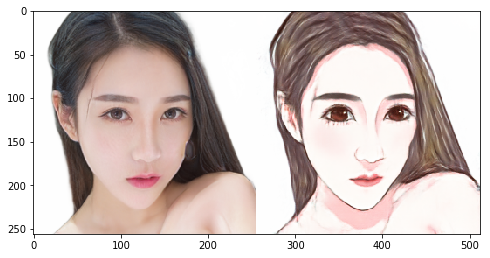

In [15]:
#读取数据
test_names = os.listdir('data/cartoon_A2B/test')
# img_name = np.random.choice(test_names)
img_name = '01481.png'
img_A2B = cv2.imread('data/cartoon_A2B/test/'+img_name)
img_A = img_A2B[:, :256]                                  # 真人图（即输入）
img_B = img_A2B[:, 256:]                                  # 漫画图（即预测结果）

# img_A= cv2.imread('data/test4.png')
# img_A = img_A[:, 256:]

g_input = img_A.astype('float32') / 127.5 - 1             # 归一化
g_input = g_input[np.newaxis, ...].transpose(0, 3, 1, 2)  # NHWC -> NCHW
g_input = paddle.to_tensor(g_input)                       # numpy -> tensor

g_output = generator(g_input)
g_output = g_output.detach().numpy()                      # tensor -> numpy
g_output = g_output.transpose(0, 2, 3, 1)[0]              # NCHW -> NHWC
g_output = g_output * 127.5 + 127.5                       # 反归一化
g_output = g_output.astype(np.uint8)

img_show = np.hstack([img_A, g_output])[:,:,::-1]
plt.figure(figsize=(8, 8))
plt.imshow(img_show)
plt.show()

## 训练200轮次的结果
![](https://ai-studio-static-online.cdn.bcebos.com/5f6c0d948d674e6bb56ba9a32c04f88b25aab738ff564d4a8f42abe5da90f81e)
